# Simulator for *PLATYPUS* and *SPATZ*

The purpose of this notebook is to simulate a measurement on one of these two instruments at ACNS. Its deficiency is that it doesn't take into account systematic errors (such as misalignment, gravity effects) and can't do background subtractions. The latter is done during an experiment to decrease $R_{min}$, which has the effect of increasing error bar size.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.stats import rv_continuous, trapz
from scipy.optimize import brentq

from refnx.reduce import PlatypusNexus as PN
from refnx.reduce.platypusnexus import calculate_wavelength_bins
from refnx.util import general, ErrorProp
from refnx.reflect import Slab, Structure, SLD, ReflectModel
from refnx.dataset import ReflectDataset

Since *PLATYPUS* and *SPATZ* are time-of-flight instruments it's necessary to have a wavelength spectrum to be able to generate neutrons of different wavelength onto the sample. We take a direct beam spectrum and convert it into a probability distribution

/Users/anz/miniconda3/envs/dev3/lib/python3.7/site-packages/refnx/reduce/platypusnexus.py:281: RuntimeWarning: Setting default pixel size to 1.177
  RuntimeWarning)


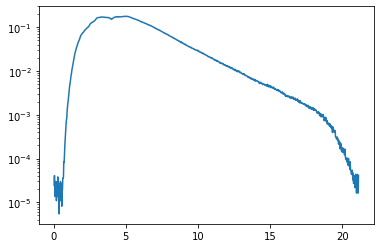

In [2]:
a = PN('PLP0000711.nx.hdf')
q, i, di=a.process(normalise=False, normalise_bins=False, rebin_percent=0, lo_wavelength=0, hi_wavelength=22)
q = q.squeeze(); 
i = i.squeeze();
di = di.squeeze()
area = simps(i, q)
i /= area
di /= area
plt.plot(q, i)
plt.yscale('log')
# plt.ylim(0, 1000)

The `SpectrumDist` object is a `scipy.stats` like object to describe the neutron intensity as a function of wavelength. You can use the `pdf, cdf, ppf, rvs` methods like you would a `scipy.stats` distribution. Of particular interest is the `rvs` method which randomly samples neutrons whose distribution obeys the direct beam spectrum. Random variates are generated the `rv_continuous` superclass by classical generation of uniform noise coupled with the `ppf`. `ppf` is approximated by linear interpolation of `q` into a pre-calculated inverse `cdf`. 

In [3]:
class SpectrumDist(rv_continuous):
    def __init__(self, x, y):
        super(SpectrumDist, self).__init__(a=np.min(x), b=np.max(x))
        self._x = x
        
        # normalise the distribution
        area = simps(y, x)
        y /= area
        self._y = y
        
        # an InterpolatedUnivariate spline models the spectrum
        self.spl = IUS(x, y)
        
        # fudge_factor required because integral of the spline is not exactly 1
        self.fudge_factor = self.spl.integral(self.a, self.b)

        # calculate a gridded and sampled version of the CDF.
        # this can be used with interpolation for quick calculation
        # of ppf (necessary for quick rvs)
        self._x_interpolated_cdf = np.linspace(np.min(x), np.max(x), 1000)
        self._interpolated_cdf = self.cdf(self._x_interpolated_cdf)

    def _pdf(self, x):
        return self.spl(x) / self.fudge_factor

    def _cdf(self, x):
        xflat = x.ravel()

        f = lambda x: self.spl.integral(self.a, x) / self.fudge_factor
        v = map(f, xflat)

        r = np.fromiter(v, dtype=float).reshape(x.shape) 
        return r

    def _f(self, x, qq):
        return self._cdf(x) - qq

    def _g(self, qq, *args):
        return brentq(self._f, self._a, self._b, args=(qq,) + args)
        
    def _ppf(self, q, *args):
        qflat = q.ravel()
        """
        _a, _b = self._get_support(*args)
    
        def f(x, qq):
            return self._cdf(x) - qq

        def g(qq):
            return brentq(f, _a, _b, args=(qq,) + args, xtol=1e-3)

        v = map(g, qflat)

        cdf = _CDF(self.spl, self.fudge_factor, _a, _b)
        g = _G(cdf)

        with Pool() as p:
            v = p.map(g, qflat)
            r = np.fromiter(v, dtype=float).reshape(q.shape)
        """
        # approximate the ppf using a sampled+interpolated CDF
        # the commented out methods are more accurate, but are at least
        # 3 orders of magnitude slower.
        r = np.interp(qflat,
                      self._interpolated_cdf,
                      self._x_interpolated_cdf)
        return r.reshape(q.shape)


# for parallelisation (can't pickle rv_continuous all that easily)
class _CDF(object):
    def __init__(self, spl, fudge_factor, a, b):
        self.a = a
        self.b = b
        self.spl = spl
        self.fudge_factor = fudge_factor

    def __call__(self, x):
        return self.spl.integral(self.a, x) / self.fudge_factor

class _G(object):
    def __init__(self, cdf):
        self.cdf = cdf

    def _f(self, x, qq):
        return self.cdf(x) - qq

    def __call__(self, q):
        return brentq(self._f, self.cdf.a, self.cdf.b, args=(q,), xtol=1e-4)

The `ReflectSimulator` class generates neutrons whose distribution follows the wavelength and angular resolution of the instrument. If uses those neutrons to calculate a reflectivity pattern based on a user supplied `ReflectModel`. The resolution properties of `ReflectModel` are ignored.

In [4]:
class ReflectSimulator(object):
    """
    Simulate a reflectivity pattern from PLATYPUS.

    Parameters
    ----------
    model: refnx.reflect.ReflectModel
    
    angle: float
        Angle of incidence (degrees)

    L12: float
        distance between collimation slits (mm)

    footprint: float
        beam footprint onto the sample (mm)

    L2S: float
        distance from pre-sample slit to sample (mm)

    dtheta: float
        Angular resolution expressed as a percentage

    lo_wavelength: float
        smallest wavelength used from the generated neutron spectrum

    hi_wavelength: float
        longest wavelength used from the generated neutron spectrum

    dlambda: float
        Wavelength resolution expressed as a percentage. dlambda=3.3
        corresponds to using disk choppers 1+3 on *PLATYPUS*.

    rebin: float
        Rebinning expressed as a percentage.

    Notes
    -----
    Angular, chopper and rebin smearing effects are all taken into account.
    """

    def __init__(self, model, angle,
                 L12=2859, footprint=60, L2S=120, dtheta=3.3, # angular resolution
                 lo_wavelength=2.8, hi_wavelength=18,
                 dlambda=3.3, rebin=2):
        self.model = model
        
        # turn off resolution smearing
        self.model.dq = 0
        self.bkg = model.bkg.value
        self.angle = angle

        # the fractional width of a square wavelength resolution
        self.dlambda = dlambda / 100.
        self.rebin = rebin / 100.
        self.wavelength_bins = calculate_wavelength_bins(lo_wavelength,
                                                         hi_wavelength,
                                                         rebin)
        # nominal Q values
        bin_centre = 0.5 * (self.wavelength_bins[1:] + self.wavelength_bins[:-1])
        self.q = general.q(angle, bin_centre)

        # keep a tally of the direct and reflected beam
        self.direct_beam = np.zeros((self.wavelength_bins.size - 1))
        self.reflected_beam = np.zeros((self.wavelength_bins.size - 1))

        # wavelength generator
        a = PN('PLP0000711.nx.hdf')
        q, i, di = a.process(normalise=False, normalise_bins=False,
                             rebin_percent=0, lo_wavelength=lo_wavelength,
                             hi_wavelength=hi_wavelength)
        q = q.squeeze(); 
        i = i.squeeze();
        self.spectrum_dist = SpectrumDist(q, i)

        # angular resolution generator, based on a trapezoidal distribution
        # The slit settings are the optimised set typically used in an
        # experiment
        self.dtheta = dtheta / 100.
        self.footprint = footprint
        s1, s2 = general.slit_optimiser(footprint, self.dtheta, angle=angle,
                                        L2S=L2S, L12=L12, verbose=False)
        div, alpha, beta = general.div(s1, s2, L12=L12)
        self.angular_dist = trapz(c=(alpha - beta)/2./alpha,
                                  d=(alpha + beta)/2./alpha,
                                  loc=-alpha,
                                  scale=2 * alpha)

    def run(self, samples):
        """
        Sample the beam.
        
        2400000 samples roughly corresponds to 1200 sec of *PLATYPUS* using
        dlambda=3.3 and dtheta=3.3 at angle=0.65.
        150000000 samples roughly corresponds to 3600 sec of *PLATYPUS* using
        dlambda=3.3 and dtheta=3.3 at angle=3.0.
        
        (The sample number <--> actual acquisition time correspondence has
         not been checked fully)
        
        Parameters
        ----------
        samples: int
            How many samples to run.
        """
        # generate neutrons of different angular divergence
        angles = self.angular_dist.rvs(samples) + self.angle
        
        # generate neutrons of various wavelengths
        wavelengths = self.spectrum_dist.rvs(size=samples)
        
        # calculate Q
        q = general.q(angles, wavelengths)

        # calculate reflectivities for a neutron of a given Q.
        r = self.model(q)

        # accept or reject neutrons based on the reflectivity of
        # sample at a given Q.
        criterion = np.random.random(size=samples)
        accepted = criterion < r

        # implement wavelength smearing from choppers
        # factor of 0.68 is used to convert from FWHM-Gaussian to
        # full-width-Uniform
        noise = np.random.random(size=samples) - 0.5
        jittered_wavelengths = wavelengths * (1 + 
                                              self.dlambda / 0.68 * noise)

        # update direct and reflected beam counts. Rebin smearing
        # is taken into account due to the finite size of the wavelength
        # bins.
        hist = np.histogram(jittered_wavelengths,
                            self.wavelength_bins)

        self.direct_beam += hist[0]
        
        hist = np.histogram(jittered_wavelengths[accepted],
                            self.wavelength_bins)
        self.reflected_beam += hist[0]

    @property
    def reflectivity(self):
        """
        The reflectivity of the sampled system
        """
        rerr = np.sqrt(self.reflected_beam)
        ierr = np.sqrt(self.direct_beam)
        dx = np.sqrt((self.dlambda)**2 + self.dtheta**2 + self.rebin**2)
        
        ref, rerr = ErrorProp.EPdiv(self.reflected_beam, rerr,
                                    self.direct_beam, ierr)
        dataset = ReflectDataset(data=(self.q, ref, rerr, dx * self.q))
        return dataset

Generate the structure you want to simulate:

In [5]:
air = SLD(0)
sio2 = SLD(3.47)
si = SLD(2.07)

s = air | sio2(225, 3) | si(0, 3)
model = ReflectModel(s, bkg=5e-7)

Create the instrument simulator and sample. Here we sample at two angles of incidence. This would correspond to *roughly* 1200 s and 3600 s on Platypus. It's possible that the acquisition time/# of samples correspondence is up to an order of magnitude out.

In [7]:
simulator0 = ReflectSimulator(model, 0.65, rebin=2)
simulator1 = ReflectSimulator(model, 3, rebin=2)

In [8]:
simulator0.run(2400000)
simulator1.run(150000000)

The `ReflectSimulator.reflectivity` attribute is a `ReflectDataset`, which can have additional data spliced onto it.

In [9]:
data = ReflectDataset()
data += simulator0.reflectivity
data += simulator1.reflectivity
data.save('sim.txt')

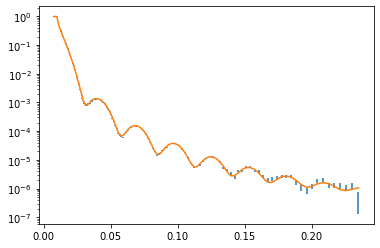

In [37]:
ebc = plt.errorbar(data.x, data.y, yerr=data.y_err)
ebc[0].set_linewidth(0)
plt.plot(data.x, model(data.x, x_err=data.x_err))
plt.yscale('log')